In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Pipeline imports
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler,FunctionTransformer
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV



In [2]:
from typing import Literal
from sklearn.base import BaseEstimator

def BMI(weight, height):
    return weight/(height**2/(100*100))

class CustomTransformer(BaseEstimator, TransformerMixin):
    """
    Transofrmer which imputes Obesity and Polydipsia parametrically with BMI and Urination
    """
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        """Expected method by the pipeline API"""
        return self

    def transform(self, X, y=None, threshold_BMI=30, threshold_Polydipsia= 2.5):
        X = self._BMI(X, threshold=threshold_BMI)
        X = self._fix_polydipsia(X, threshold=threshold_Polydipsia)
        return X
    
    def _BMI(self, X, y=None, threshold=30):
        # Perform arbitary transformation
        idx = X[X['Obesity'].isna()].index
        
        # indexes to identify BMI above or below threshold
        idx2 = X.loc[idx,].loc[BMI(X.loc[idx,]["Weight"], X.loc[idx,]["Height"]) <= threshold].index
        idx3 = X.loc[idx,].loc[BMI(X.loc[idx,]["Weight"], X.loc[idx,]["Height"]) > threshold].index
        
        # set obesity from indexes above
        X.loc[idx2,'Obesity'] = 0
        X.loc[idx3,'Obesity'] = 1
        return X
    
    def _fix_polydipsia(self, df, threshold=2.5):
        idx = df[df['Polydipsia'].isna()].index
        
        # indexes to identify Urination above or below threshold
        idx2 = df.loc[idx,].loc[df['Urination'] <= threshold].index
        idx3 = df.loc[idx,].loc[df['Urination'] > threshold].index

        # set Polydipsia from indexes above
        df.loc[idx2,'Polydipsia'] = 0
        df.loc[idx3,'Polydipsia'] = 1
        #df.loc[idx,]
        return df
    
    def set_output(self, *, transform: Literal['default', 'pandas'] | None = None) -> BaseEstimator:
        return super().set_output(transform=transform)


class AddBMI(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        """Expected method by the pipeline API"""
        return self

    def transform(self, X, y=None):
        X['BMI'] = BMI(X['Weight'], X['Height'])
        return X
    
    def set_output(self, *, transform: Literal['default', 'pandas'] | None = None) -> BaseEstimator:
        return super().set_output(transform=transform)

class Outliers(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        """Expected method by the pipeline API"""
        return self

    def transform(self, X: pd.DataFrame, y=None):
        df = X[self.features].copy()
        mask = abs((df - df.mean())/df.std()) > 3 # Standardize
        X[mask] = np.NaN
        return X
    
    def get_feature_names_out(self, *args, **params):
        """
        method which enables pass through of column names, preserving them in the final transformed data frame
        """
        return self.columns_



# Read data

I chose to read data directly for ease of testing

In [3]:

# diabetes = pd.read_csv('diabetes.csv')
diabetes = pd.read_csv('anon.csv')
binary_features = ['Obesity', 'TCep', 'Polydipsia', 'Sudden Weight Loss', 'Weakness',
                'Polyphagia', 'Genital Thrush', 'Visual Blurring', 'Itching',
                'Irritability', 'Delayed Healing', 'Partial Paresis', 'Muscle Stiffness', 'Alopecia', 'Gender']
cat_features = ['Race',	'Occupation',	'GP']
num_features = ['Age',	'Height',	'Weight',	'Temperature',	'Urination']


target = 'Diabetes'
y = diabetes[target]
X = diabetes.drop(columns=(target))


# features reomved here will not be included in the analysis
num_features.remove('Urination')
cat_features.remove('GP')
cat_features.remove('Race')
binary_features.remove('TCep')


# Some helpers

In [4]:
def fix_height(x, threshold=100):
    """ Converts height in meters to centimeters, if height is less than threshold (default = 100)"""
    col = x.columns[0]
    mask = x[col] < threshold
    x.loc[mask, [col]] = x.loc[mask, [col]].mul(100)
    return x

def fix_formating(x):
    return x.replace({'yes':1, 'Yes': 1, 'Positive':1, 'no':0, 'No':0, 'Negative':0, 'Male':1,'Female':0})


## $\epsilon$ privacy

# Constructing Pipeline

I compose the pipeline from smaller pipelines, which all handles a subset of the tasks.

The numeric, binary and categorical columns are all handled differently. 
In addition, construct a parametric preprocessor where we can impute with domain knowledge. We must adapt the functions from the other script to do so, and I have only done that to a few easy ones.

For transformations which rely on other columns, like fixing obesity and polydipsia, we must use a slightly more complicated approach with classes, which I haven't attempted yet.

Row wise transformations, like outliers, must also be implemented, and I have not looked at that either.

In [5]:
# Parametric preprocessor where we impute with domain knowledge
preprocessor_parametric = ColumnTransformer(
    transformers=[
        # ('fix height', FunctionTransformer(fix_height), ['Height']),
    ],
    verbose_feature_names_out= False, # Keeps the same column name for future processing
    remainder='passthrough'         # Doesent drop untransformed columns
).set_output(transform='pandas')    # Keep data frame format

binary_transformer = Pipeline(
    steps=[
        ('Fix formating', FunctionTransformer(fix_formating)),
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        # ('randomize', FunctionTransformer(randomize)), # privacy has been moved to a separate pipeline
        # ("selector", SelectKBest(k=5)),
    ]
)

cat_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=0.1, sparse=False)),
        # Unsure how to introduce privacy,
        # ("selector", SelectKBest(k=5)),
    ]
)

num_transformer = Pipeline(
    steps=[
           # Differential privacy here
           # Outliers Here
            ('Outliers', Outliers(num_features)), 
            ("imputer", SimpleImputer(strategy="mean")), 
            ("scaler", StandardScaler())]
)


# General preprocesser which encodes and scales all features
preprocessor_general = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features),
        ('binary', binary_transformer, binary_features)
    ],
    verbose_feature_names_out= True,
    remainder='drop'                # drop untouched features since after this step, as it is the last preprocessing one
).set_output(transform="pandas")    # Keep data frame format


preprocessor = Pipeline(
    steps=[
        ('Custom impute', CustomTransformer()),
        # ('Add columns', AddBMI()),
        ("preprocessor parametric", preprocessor_parametric), 
        ("preprocessor general", preprocessor_general), 
        ]
)


clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ("classifier", tree.DecisionTreeClassifier())
        ]
)


def make_clf(clf):
    return Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ("classifier", clf)
        ]
    )

clf # Displays the pipeline


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('Custom impute', CustomTransformer()),
                                 ('preprocessor parametric',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[],
                                                    verbose_feature_names_out=False)),
                                 ('preprocessor general',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('Outliers',
                                                                                    Outliers(features=['Age',
                                                                                                       'Height',
                                                                                                       'Weight',
                                                                                                       'Temperature']...
                                                                                    FunctionTransformer(func=<function fix_formating at 0x154c6d260>)),
                                                                                   ('imputer',
                                                                                    SimpleImputer(fill_value=0,
                                                                                                  strategy='constant'))]),
                                                                   ['Obesity',
                                                                    'Polydipsia',
                                                                    'Sudden '
                                                                    'Weight '
                                                                    'Loss',
                                                                    'Weakness',
                                                                    'Polyphagia',
                                                                    'Genital '
                                                                    'Thrush',
                                                                    'Visual '
                                                                    'Blurring',
                                                                    'Itching',
                                                                    'Irritability',
                                                                    'Delayed '
                                                                    'Healing',
                                                                    'Partial '
                                                                    'Paresis',
                                                                    'Muscle '
                                                                    'Stiffness',
                                                                    'Alopecia',
                                                                    'Gender'])]))])),
                ('classifier', DecisionTreeClassifier())])

# Running pipeline
## Predicting


In [6]:

X_train, X_test, y_train, y_test = train_test_split(X, y) # Simple train-test spliot

clf.fit(X_train, y_train)
print("Train score: %.3f" % clf.score(X_train, y_train))
#print("Test score: %.3f" % clf.score(X_test, y_test))

Train score: 1.000


## Transformed data frame

Allows inspection into the final preprocessed data frame which the prediction model trains on

In [7]:
display(preprocessor.fit_transform(X_train, y_train))


,num__Age,num__Height,num__Weight,num__Temperature,cat__Occupation_Manager,cat__Occupation_Retired,cat__Occupation_infrequent_sklearn,binary__Obesity,binary__Polydipsia,binary__Sudden Weight Loss,...,binary__Polyphagia,binary__Genital Thrush,binary__Visual Blurring,binary__Itching,binary__Irritability,binary__Delayed Healing,binary__Partial Paresis,binary__Muscle Stiffness,binary__Alopecia,binary__Gender
328,2.043577,4.489269e-01,-9.244239e-16,0.348666,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
490,0.939536,-3.917419e-01,1.715163e+00,0.296748,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
387,-1.268545,-1.262714e+00,-2.239934e-01,0.660174,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,-0.674062,6.219483e-01,7.829891e-01,-0.170515,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
167,-1.523324,1.171316e+00,3.191787e-01,-1.779976,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0.854610,-2.778284e-15,1.786719e+00,0.660174,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
232,-0.419283,3.257592e-01,-6.559291e-01,-1.053123,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
528,-1.693176,-1.275422e+00,-1.281715e+00,-0.326270,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
234,-0.079578,2.162767e-01,8.025043e-01,-1.105041,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0


In [8]:
for depth in range(1,20):
    scores = cross_val_score(make_clf(tree.DecisionTreeClassifier(max_depth=depth)), X_train, y_train, cv=5)
    print(f"depth: {depth}, cv score: {np.mean(scores):.3f}")


depth: 1, cv score: 0.775
depth: 2, cv score: 0.844
depth: 3, cv score: 0.822
depth: 4, cv score: 0.865
depth: 5, cv score: 0.858
depth: 6, cv score: 0.839
depth: 7, cv score: 0.834
depth: 8, cv score: 0.836
depth: 9, cv score: 0.839
depth: 10, cv score: 0.826
depth: 11, cv score: 0.829
depth: 12, cv score: 0.839
depth: 13, cv score: 0.841
depth: 14, cv score: 0.844
depth: 15, cv score: 0.846
depth: 16, cv score: 0.834
depth: 17, cv score: 0.834
depth: 18, cv score: 0.819
depth: 19, cv score: 0.841


## Cross validation for parameter tuning

I implemented a grid search of the parameter space (currently only the max depth, but it can easily be expanded).

In [9]:

param_grid = {
    'classifier__ccp_alpha' : np.linspace(0, 0.001, 10),
    'classifier__max_depth' : list(range(1,10))
}

def tune_clf(clf, X_train, y_train, param_grid=param_grid):
    """
    Tunes a model with a grid search of the parameter space, then returns a model trained on the optimal hyperparameters.

    ----
    returns:
    {
        'model',
        'train score'
    }
    """
    model = GridSearchCV(clf, param_grid=param_grid).fit(X_train, y_train)
    best_model = model.best_estimator_.fit(X_train, y_train)
    # print(best_model['classifier'].max_depth)
    return {'model': best_model, 'train score': best_model.score(X_train, y_train)}


In [10]:
model = tune_clf(make_clf(tree.DecisionTreeClassifier(ccp_alpha=0.1)), X_train, y_train)['model']
model['classifier']


DecisionTreeClassifier(ccp_alpha=0.00044444444444444447, max_depth=5)

### Evaluating multiple metrics



In [11]:
from sklearn.metrics import confusion_matrix 

def score(model, X, y):
    """
    Accepts a model (implementing a .predict method) and some data, X, with labels y, 
    and returns the accuracy, precision, recall and F1 score.

    Warning: the lenght of the return value is assumed to be equal to the lenght of the socre names

    """
    y_hat = model.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, y_hat).ravel()
    acc = (tp + tn)/(tp + fp + fn + tn)
    prec = (tp)/(tp + fp)
    rec = (tp)/(tp + fn)
    f1 = 2*prec*rec/(prec+rec)


    return acc, prec, rec, f1

score_names = ['accuracy', 'precision', 'recall', 'F1']

score(model, X_test, y_test)




(0.8613138686131386,
 0.8947368421052632,
 0.8607594936708861,
 0.8774193548387097)

### Some bootstrapping

In [12]:
from sklearn.utils import resample

n_samples = 20
models = []
train_scores = np.zeros(shape=(n_samples, len(score_names)))
test_scores = np.zeros_like(train_scores)

train = X_train
train['Diabetes'] = y_train

for i in range(n_samples):
    print(f'{i/n_samples:.2f}')

    # train_b = train.sample(replace = True, n=len(train.index))
    # y_b = train_b[target]
    # X_b = train_b.drop(columns=(target))

    X_train, X_test, y_train, y_test = train_test_split(X, y) # Simple train-test split
    model =  tune_clf(make_clf(tree.DecisionTreeClassifier()), X_train, y_train)['model']
    train_scores[i] = score(model, X_train, y_train)


    test_scores[i] = score(model, X_test, y_test)
    models.append(model['classifier'])

train_scores = pd.DataFrame(train_scores,columns=score_names)
test_scores = pd.DataFrame(test_scores,columns=score_names)

0.00
0.05
0.10
0.15
0.20
0.25
0.30
0.35
0.40
0.45
0.50
0.55
0.60
0.65
0.70
0.75
0.80
0.85
0.90
0.95


### Plots distribution of hyperparmeters

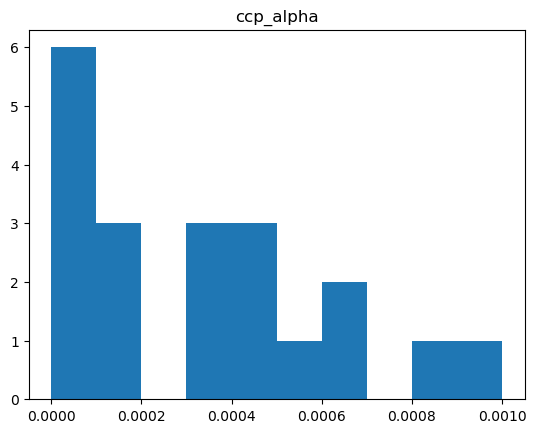

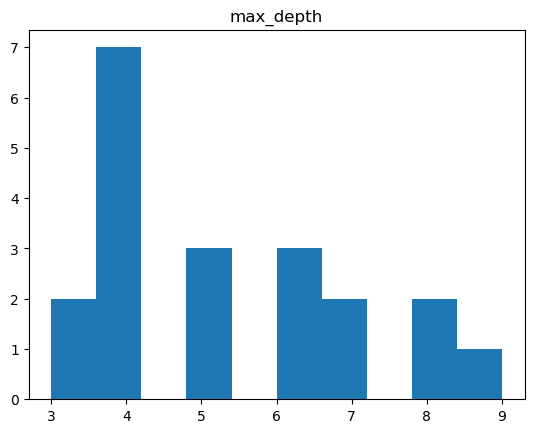

In [13]:
for param in param_grid.keys():
    param = param.split('__')[1] # we ignore the 'classifier__' prefix
    ls = [getattr(model, param) for model in models]

    plt.hist(ls)
    plt.title(param)
    plt.show()
None

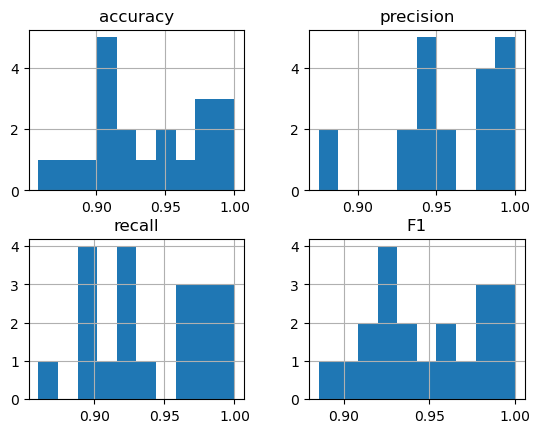

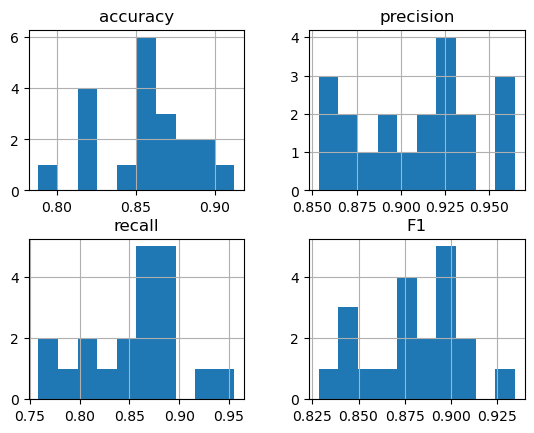

In [14]:
# train_scores.plot(kind = 'hist', title='train scores',subplots=True)
train_scores.hist()
test_scores.hist()
None # hides ugly last line

In [15]:
# Visualize the feature importance
feature_importance = {}
for model in models:
    fnames = model.feature_names_in_
    fimp = model.feature_importances_

    for i in list(zip(fnames,fimp)):
        if i[0] in feature_importance.keys():
            feature_importance[i[0]] = feature_importance[i[0]] + [i[1]]
        else:
            feature_importance[i[0]] =[i[1]]

# add zero until all


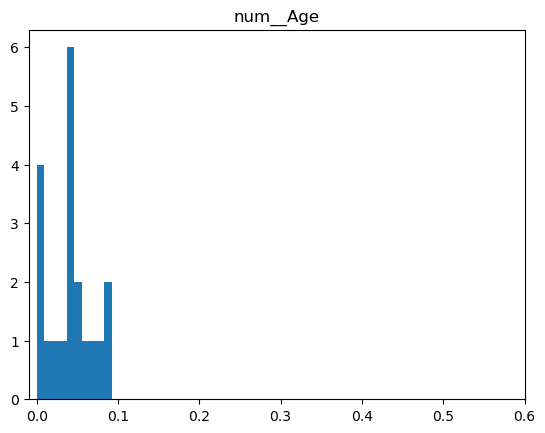

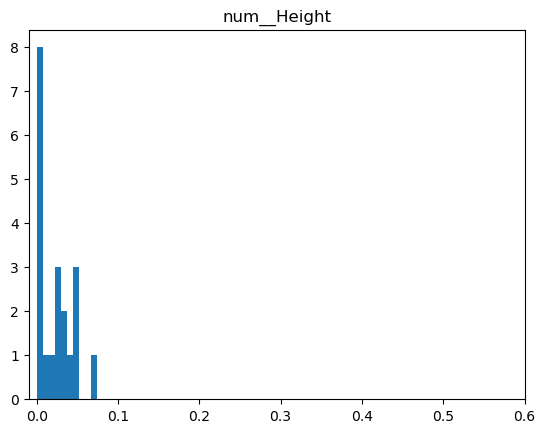

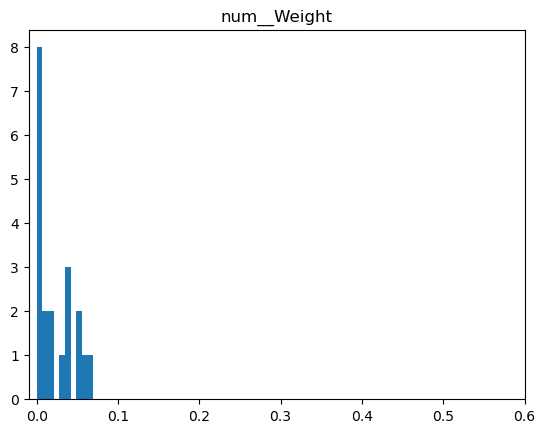

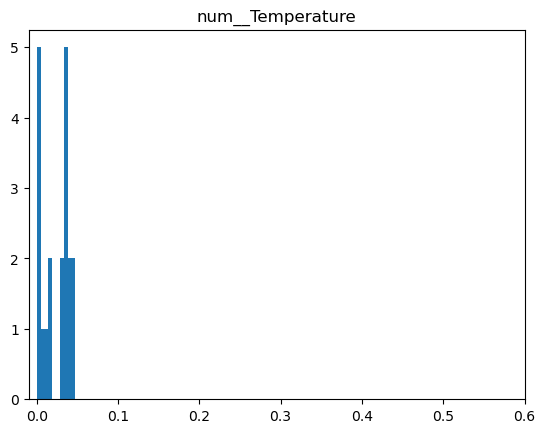

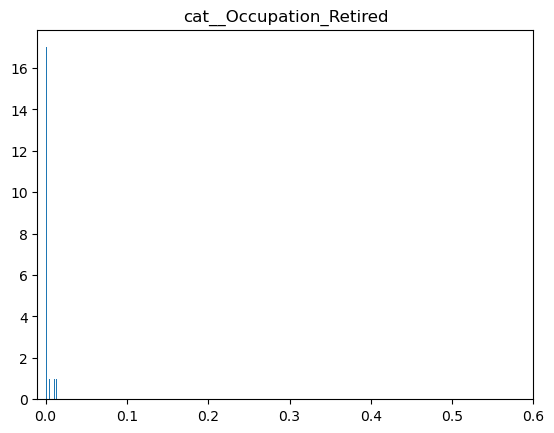

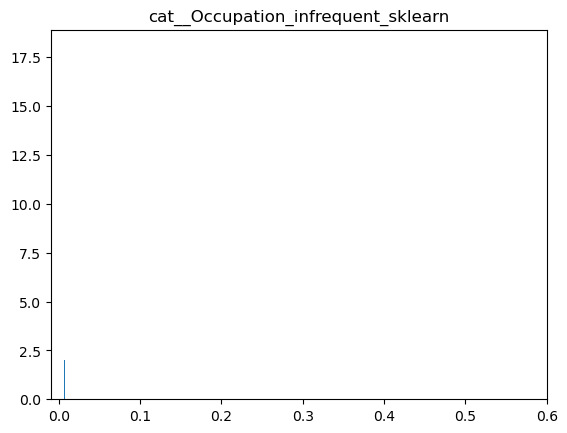

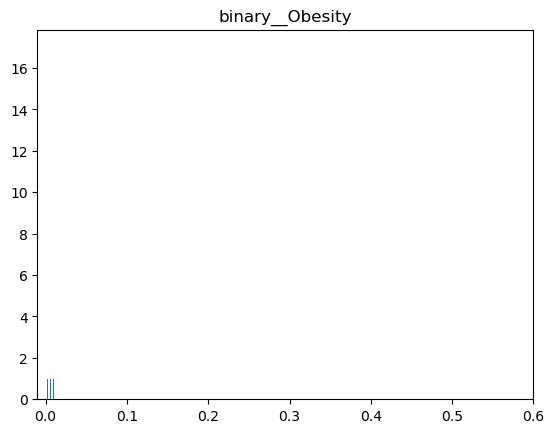

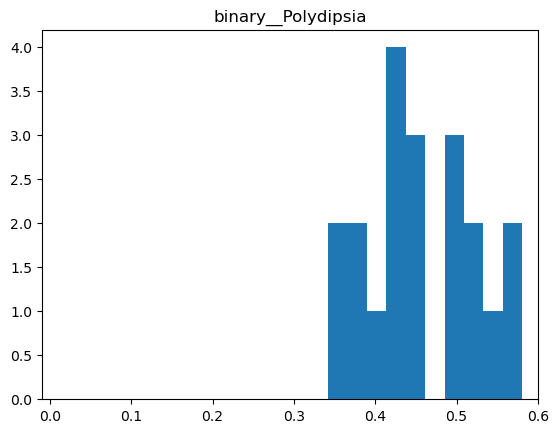

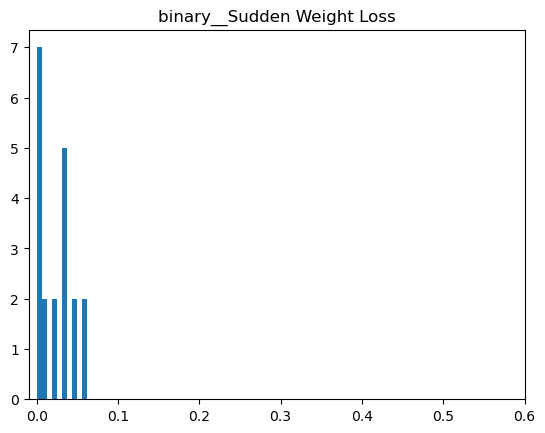

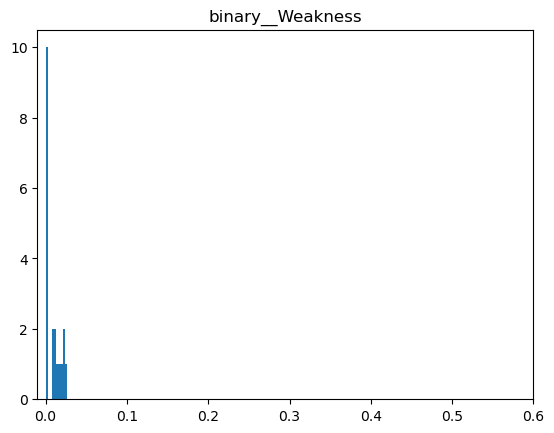

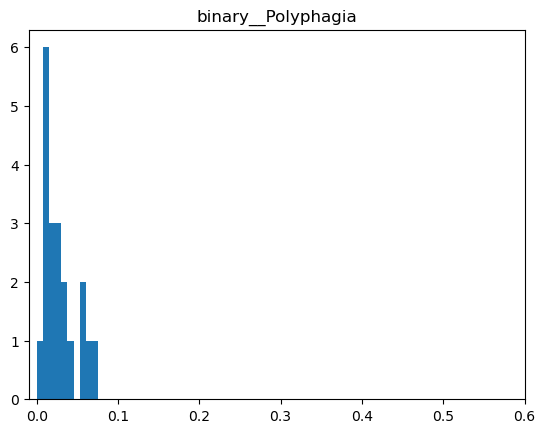

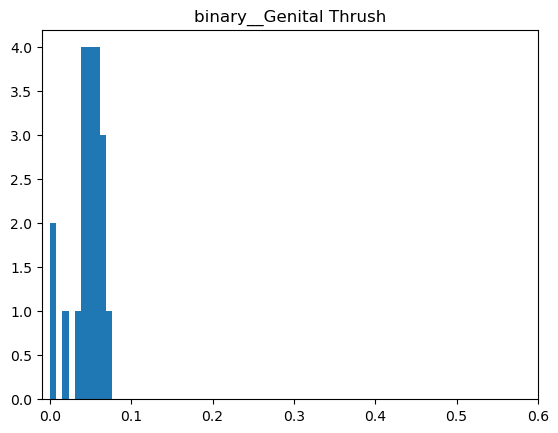

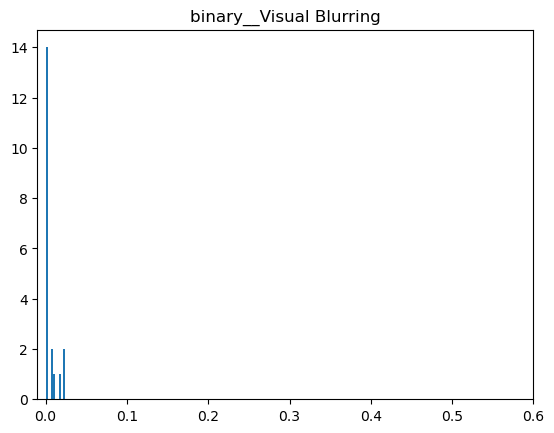

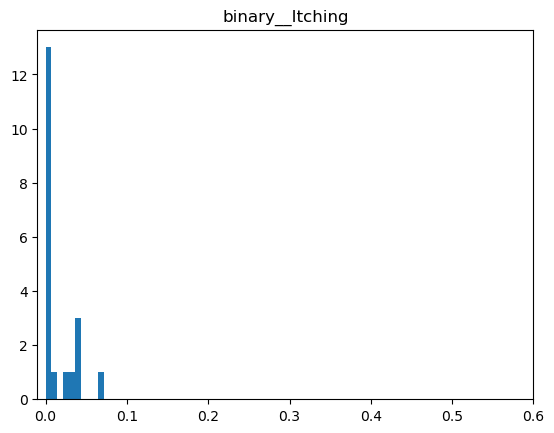

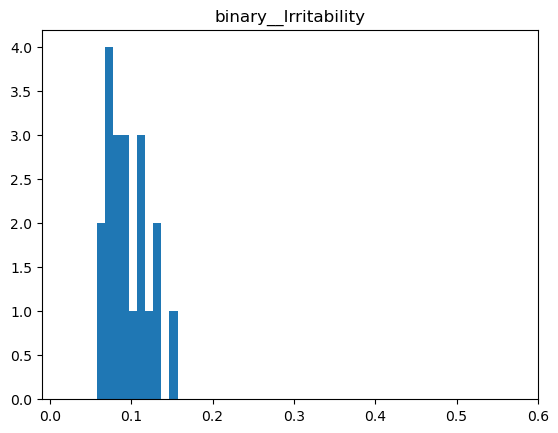

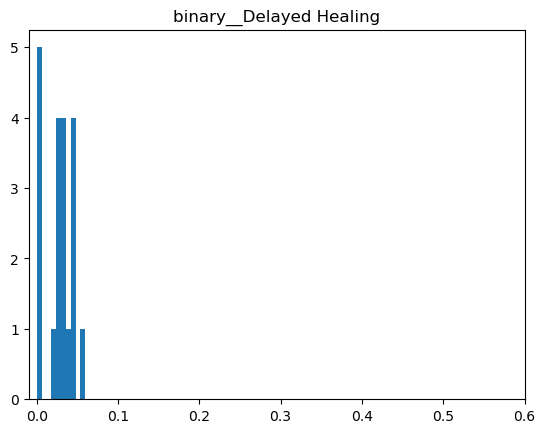

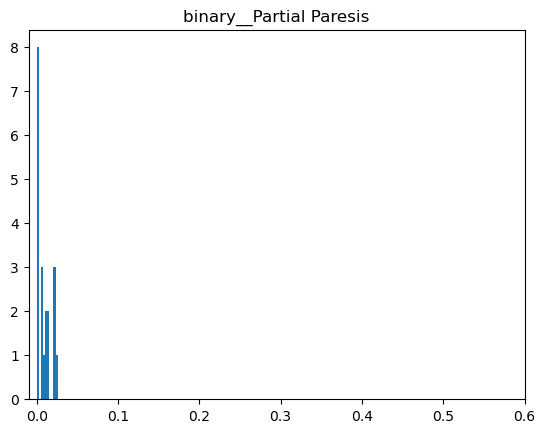

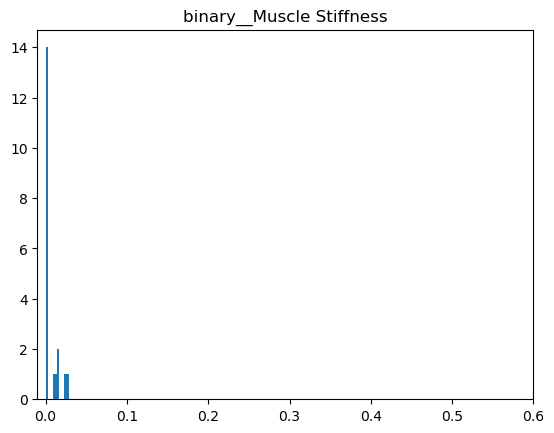

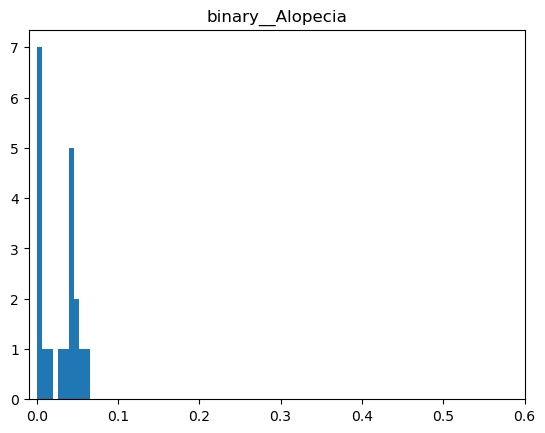

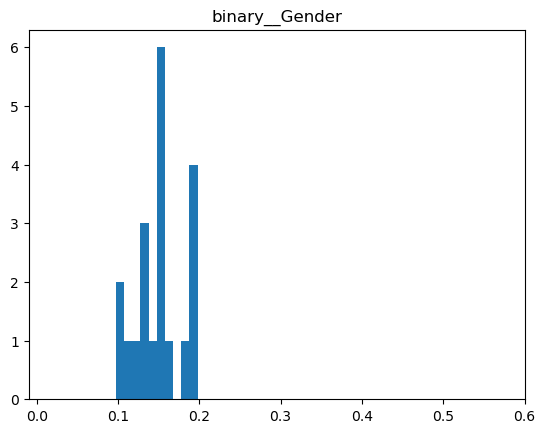

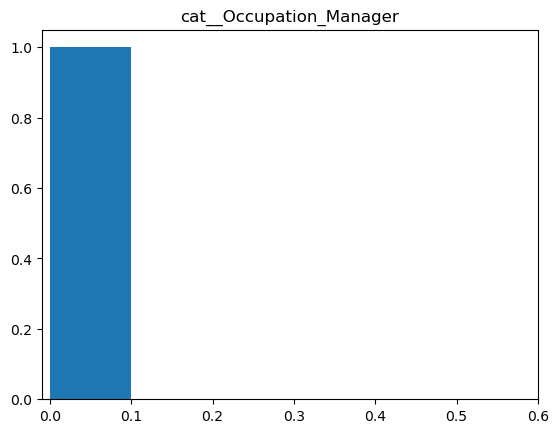

In [16]:
for feature in feature_importance.keys():
    plt.hist(feature_importance[feature])
    plt.title(feature)
    plt.xlim([-0.01,0.6])
    plt.show()